In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from risparser import convert_ris_to_csv

## Convert RIS files into CSV

In [2]:
raw_files = [raw_files for raw_files in os.listdir("raw") if raw_files.endswith(".ris")]
os.makedirs("csv", exist_ok=True)
for ris_file in raw_files :
    ris_fp = os.path.join("raw", ris_file)
    csv_fp = os.path.join("csv", os.path.splitext(ris_file)[0]+".csv")
    convert_ris_to_csv(ris_fp, csv_fp)

Input file: raw/schoot-lgmm-ptsd-initial.ris
Number of articles: 6187
Export file: csv/schoot-lgmm-ptsd-initial.csv
Input file: raw/schoot-lgmm-ptsd-included-1.ris
Number of articles: 363
Export file: csv/schoot-lgmm-ptsd-included-1.csv
Input file: raw/schoot-lgmm-ptsd-included-3.ris
Number of articles: 8
Export file: csv/schoot-lgmm-ptsd-included-3.csv
Input file: raw/schoot-lgmm-ptsd-included-2.ris
Number of articles: 38
Export file: csv/schoot-lgmm-ptsd-included-2.csv


## Clean the data 

(Code from the R file)

In [3]:
# original papers
all_data = pd.read_csv("csv/schoot-lgmm-ptsd-initial.csv")
# included papers
inc_data = pd.read_csv("csv/schoot-lgmm-ptsd-included-2.csv")
# After abstract screening
aas_data = pd.read_csv("csv/schoot-lgmm-ptsd-included-1.csv")
# Directly included after reading the abstract
dir_data = pd.read_csv("csv/schoot-lgmm-ptsd-included-3.csv")

# all titles (clean)
all_title = all_data["title"].str.replace("[^A-Za-z0-9]", "", regex=True)
# included titles (clean)
inc_title = inc_data["title"].str.replace("[^A-Za-z0-9]", "", regex=True)
# After abstract screening title
aas_title = aas_data["title"].str.replace("[^A-Za-z0-9]", "", regex=True)
# Directly included
dir_title = dir_data["title"].str.replace("[^A-Za-z0-9]", "", regex=True)

In [4]:
# papers missing from original dataset
inc_missing = ~inc_title.str.lower().isin(all_title.str.lower())
aas_missing = ~aas_title.str.lower().isin(all_title.str.lower())

print("Papers included, missing from initial data:              ", inc_missing.sum(), "\n")
print("Papers in abstract screening, missing from initial data: ", aas_missing.sum(), "\n\n")

Papers included, missing from initial data:               0 

Papers in abstract screening, missing from initial data:  2 




In [5]:
# Add missing papers to original dataset.
all_data = all_data.append(aas_data[aas_missing], sort=False).reset_index(drop=True)
all_data = all_data.append(inc_data[inc_missing], sort=False).reset_index(drop=True)

# Update "cleaned" titles with new additions.
all_title = all_data["title"].str.replace("[^A-Za-z0-9]", "", regex=True)

In [6]:
# train data
label_inc = all_title.str.lower().isin(inc_title.str.lower())
label_aas = all_title.str.lower().isin(aas_title.str.lower())
label_dir = all_title.str.lower().isin(dir_title.str.lower())

CODE_EXCLUDE = 0      # Exclude paper.
CODE_AFT_EXCLUDE = 1  # Exclude after reading full text.
CODE_AFT_INCLUDE = 2  # Include after reading full text.
CODE_AAS_INCLUDE = 3  # Include after reading abstract.

inclusion_code = (label_aas & ~label_inc)*CODE_AFT_EXCLUDE
inclusion_code = inclusion_code + (label_inc & ~label_dir)*CODE_AFT_INCLUDE
inclusion_code = inclusion_code + label_dir*CODE_AAS_INCLUDE

train_data = all_data.assign(included = label_inc.astype(int), inclusion_code = inclusion_code)
train_data = train_data.assign(authors = train_data["authors"].str.replace("[\\[']", "", regex=True))
train_data = train_data.assign(authors = train_data["authors"].str.replace("\\]", "", regex=True))

In [7]:
# duplicates
n_dup = all_title.str.lower().duplicated().sum()
n_uni = (~all_title.str.lower().duplicated()).sum()
print("Number of duplicated papers:", n_dup, "\n")
print("Number of unique papers:    ", n_uni, "\n\n")

# remove duplicates based on just titles
train_data = train_data[(~all_title.str.lower().duplicated()) | all_title.str.lower().isnull()]

Number of duplicated papers: 470 

Number of unique papers:     5719 




In [8]:
# reorder columns (nothing special)
def order_columns(df):
    
    cols = df.columns.tolist()
    label_cols = ['included', 'inclusion_code']
    cols.sort()
    cols = [elem for elem in cols if elem not in label_cols]
    return df[cols + label_cols]

train_data = order_columns(train_data)

## Export datasets

In [9]:
train_data.to_csv("csv/PTSD_VandeSchoot_18.csv", index=False)

## Datasets statistics

In [10]:
print("Number of papers with missing title:              ", all_title.isna().sum(), "\n")
print("Number of papers with missing abstract:           ", train_data['abstract'].isna().sum(), "\n")
print("Number of papers with missing title AND abstract: ", (all_title.isna() & train_data['abstract'].isna()).sum(), "\n")
print("Number of papers with missing title OR abstract:  ", (all_title.isna() | train_data['abstract'].isna()).sum(), "\n\n")

Number of papers with missing title:               64 

Number of papers with missing abstract:            747 

Number of papers with missing title AND abstract:  62 

Number of papers with missing title OR abstract:   749 




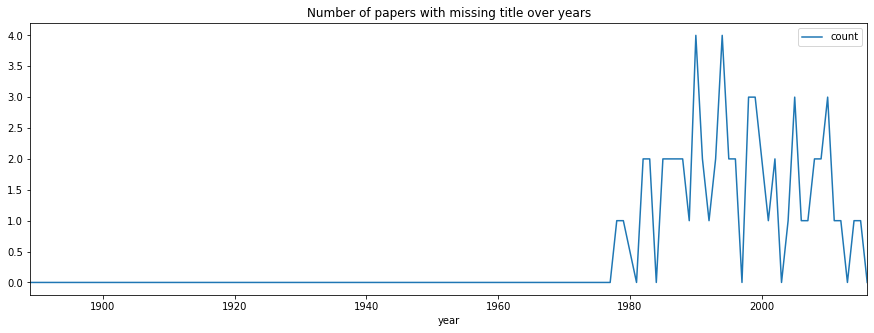

In [11]:
# missing title over years
train_data.loc[train_data.year == 0, "year"] = np.nan
train_data["title"].isna().groupby(train_data["year"]).sum().astype(int).\
reset_index(name="count").set_index("year").\
plot(figsize=(15,5))
plt.title("Number of papers with missing title over years")
plt.show()

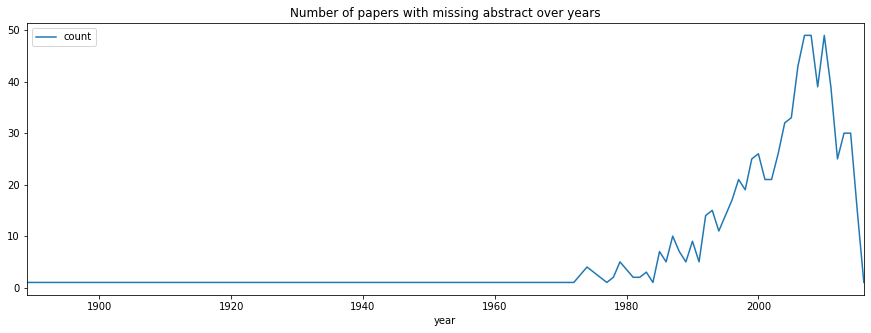

In [12]:
# missing abstract over years
train_data["abstract"].isna().groupby(train_data['year']).sum().astype(int).\
reset_index(name='count').set_index('year').\
plot(figsize=(15,5))
plt.title("Number of papers with missing abstract over years")
plt.show()

In [13]:
n_train = len(train_data['included'])
n_inc = train_data['included'].sum()
n_exc = n_train-n_inc

n_aas_exc = (train_data['inclusion_code'] == 0).sum()
n_aft_exc = (train_data['inclusion_code'] == CODE_AFT_EXCLUDE).sum()
n_aft_inc = (train_data['inclusion_code'] == CODE_AFT_INCLUDE).sum()
n_aas_inc = (train_data['inclusion_code'] == CODE_AAS_INCLUDE).sum()

print("Total remaining papers in training set:     ", n_train, "\n")
print("Total EXCLUSIONS after abstract screening:  ", n_aas_exc, "\n")
print("Total EXCLUSIONS after full text screening: ", n_aft_exc, "\n")
print("Total INCLUSIONS after full text screening: ", n_aft_inc, "\n")
print("Total INCLUSIONS after abstract screening:  ", n_aas_inc, "\n\n")
print("Total number of INCLUSIONS:                 ", n_inc, " (", round(100*n_inc/n_exc, 2), "% )\n")
print("Total number of EXCLUSIONS:                 ", n_exc, "\n\n")

Total remaining papers in training set:      5782 

Total EXCLUSIONS after abstract screening:   5426 

Total EXCLUSIONS after full text screening:  318 

Total INCLUSIONS after full text screening:  30 

Total INCLUSIONS after abstract screening:   8 


Total number of INCLUSIONS:                  38  ( 0.66 % )

Total number of EXCLUSIONS:                  5744 


